In [174]:
# Do zrobienia: 
# Dodać skalę so spektrogramów
# wyrzucić my_specgram do osobnego pliku i stosować jako bibliotekę (moduł)
# Sprawdzić jak zachowują się korelacje jeśli zamiast lorentzianu w domenie częstotliwości 
# dodamy sinusa w domenie czasu - zrobione

# Zastanowić się, czy nie usprawnić procesu modelowania sygnałów przez napisanie osobnej funkcji
# zamieszczenie jej w osobnym module i przywoływanie z dużą liczbą argumentów


# Funckja korelacji dla zaszumionych sygnałów o krótkim czasie trwania

# Domena cząstotliwości

import numpy as np
import math
from scipy import signal
import seaborn as sns
import cmath as cm
import matplotlib.pyplot as plt

sampleRate = 512
timeRange = 10 * 60 # s (długość sygnału czasowego)


timeNum = timeRange * sampleRate
freqNum = int ( timeRange/2 * sampleRate + 1 )  # liczba punktów na wykresie (w domenie częstotliwości) +1 wynika z tego, że wykres zaczyna się od 0 Hz
freqRange = sampleRate/2
freqScale = (freqNum-1)/freqRange

timeLine = np.linspace(0, timeRange, timeNum) # oś czasu
freq = np.linspace(0, freqRange, freqNum) # oś częstotliwości 

spec = np.zeros((3,freqNum)) # deklaracja trzech pustych tablic (dla każdego sygnału)
freqSig = np.zeros((3,freqNum), dtype = complex) # deklaracja tablicy (analogicznie do spec)
timeSig = np.zeros((3,timeNum))
freqCut = np.zeros(3) # tablica częstotliwości odcięcia


            
# modyfikacja funkcji specgram (więcej w pliku my_specgram):
# DO POPRAWY: nauczyć się samodzielnie robić moduły i zrobić osobny moduł myspecgram, 
# który można przywołać w innym notebooku

from matplotlib import *
from pylab import *
def my_specgram(x, NFFT=256, Fs=2, Fc=0, detrend=mlab.detrend_none,
             window=mlab.window_hanning, noverlap=128,
             cmap=None, xextent=None, pad_to=None, sides='default',
             scale_by_freq=None, minfreq = None, maxfreq = None, **kwargs):
    
    ax = gca() # gca = current axis
    Pxx, freqs, bins = mlab.specgram(x, NFFT, Fs, detrend,
         window, noverlap, pad_to, sides, scale_by_freq)

    # modified here
    #####################################
    if minfreq is not None and maxfreq is not None:
        Pxx = Pxx[(freqs >= minfreq) & (freqs <= maxfreq)]
        freqs = freqs[(freqs >= minfreq) & (freqs <= maxfreq)]
    #####################################

    Z = 10. * np.log10(Pxx)
    Z = np.flipud(Z)

    if xextent is None: xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    freqs += Fc
    extent = xmin, xmax, freqs[0], freqs[-1]
    im = ax.imshow(Z, cmap, extent=extent, **kwargs)
    ax.axis('auto')

    return Pxx, freqs, bins, im

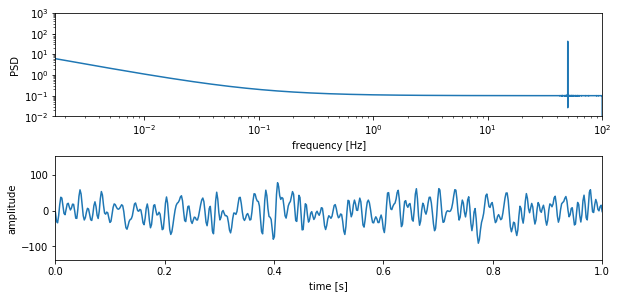

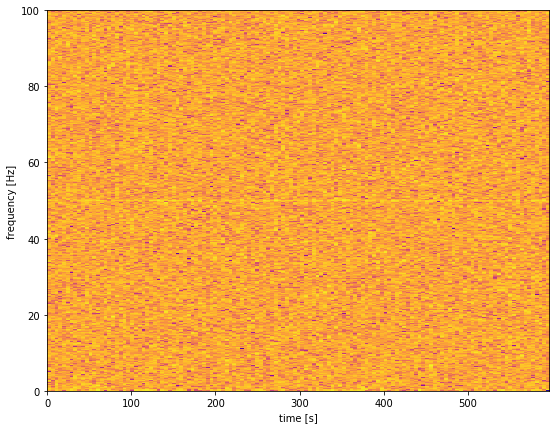

In [202]:
# Pierwszy sygnał

s = 0 # numer sygnału 

freqCut[s] = 100 # Hz (częstotliwość odcięcia)
noiseFloor = 0.1 
pinkNoiseAmp = 0.01 

cut = int(freqCut[s] * freqScale)
spec[s] = np.zeros(freqNum)
for i in range(1,cut+1,1):
    spec[s][i] = noiseFloor + pinkNoiseAmp / freq[i] # szum 1/f + szum biały

    
# zespolona amplituda szumu w domenie częstotliwości (z losowo nadanymi fazami) 
# freqSig1 zawiera pełną informację o sygnale
freqSig[s] = np.sqrt(spec[s])/2 + 0*1j # amplituda sygnału - pierwiastek z mocy (liczba zespolona)
for i in range(freqNum):
    freqSig[s][i] = freqSig[s][i] * np.exp(1j * 2*np.pi * np.random.uniform(0,1)) # nadaję losową fazę amplitudzie 

# można próbować dodać funkcję zespoloną w funkcji częstotliwości, która odpowiada jakiemuś sygnałowi czasowemu
"""
lorWidth = 150 # szerokość funkcji (jednostka: Hz)
lorAmp = 10 # amplituda funkcji
gamma = 0.001 # parametr funkcji
position = 50 * sampleRate # pozycja środka dodawanego sygnału

x = np.linspace(0, lorWidth, lorWidth*sampleRate) # oś czasu
lor = np.sqrt( lorAmp / (1 + np.power((x-lorWidth/2)/gamma,2)) ) + 0*1.j
# nadanie fazy:
lor = lor * np.exp( 1j * 2*np.pi * np.arctan((x-lorWidth/2/gamma) % 2*np.pi) )
for i in range(int(position - x.size/2), int(position + x.size/2),1):
    freqSig[s][i] = freqSig[s][i] + lor[i - int((position - x.size/2))]
"""
    
# odwrotna FFT - przejście do domeny czasu

timeSig[s] = (freqNum-1)*np.fft.irfft(freqSig[s]).real

# można też dodać przebieg czasowy

sigWidth = 600 # szerokość funkcji (jednostka: s)
sigAmp = 10 # kwadrat amplitudy funkcji
position = 300 * sampleRate # pozycja środka dodawanego sygnału
frequency = 50 # Hz

x = np.linspace(0, sigWidth, sigWidth*sampleRate) # oś czasu
sig = sqrt(sigAmp) * np.sin(frequency * x * 2*np.pi) 
for i in range(int(position - x.size/2), int(position + x.size/2),1):
    if i <= timeNum and i >= 0:
        timeSig[s][i] = timeSig[s][i] + sig[i - int((position - x.size/2))]

# powrót do domeny częstotliwości        

freqSig[s] = np.fft.rfft(timeSig[s])/(freqNum-1)
spec[s] = np.power(2*abs(freqSig[s]),2)
    
    
# wykres

#PSD
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(freq[1:], spec[s][1:])
ax1.set(yscale = 'log', xscale = 'log', xlim = (1/freqScale,freqCut[s]), ylim = (0.01, 1000),
        xlabel = "frequency [Hz]", ylabel = "PSD")

# przebieg czasowy
ax2.plot(timeLine, timeSig[s])
ax2.set(xlabel = "time [s]", ylabel = "amplitude", xlim = (0,1))

# spektrogram

fig2, (ax3) = plt.subplots(1,1)
plt.sca(ax3)
ax3.set(xlabel = "time [s]", ylabel = "frequency [Hz]", ylim = (0,freqCut[s]), yscale = 'linear')
Pxx, freqs, bins, im = my_specgram(timeSig[s], NFFT=int(5 * sampleRate), 
                                       Fs=sampleRate, noverlap=int(sampleRate/2), 
                                       cmap = 'plasma',
                                       minfreq = 0, maxfreq = freqCut[s])

# ustawienia wykresu
fig.tight_layout(pad = 0.5) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(4)
fig.set_figwidth(9)
fig2.set_figheight(7)
fig2.set_figwidth(9)
plt.show()

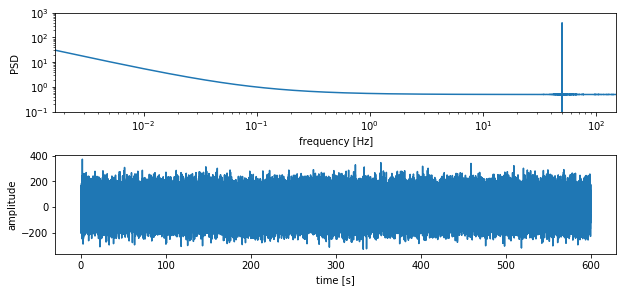

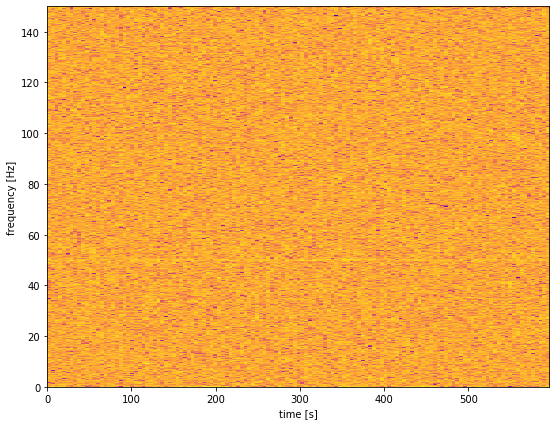

In [203]:
# Drugi sygnał 
s = 1

freqCut[s] = 150 # Hz (częstotliwość odcięcia)
noiseFloor = 0.5 
pinkNoiseAmp = 0.05

cut = int(freqCut[s] * freqScale)
spec[s] = np.zeros(freqNum)
spec[s] = np.array(spec[s]) # spec = spectrum, deklaracja pustej tablicy N-elementowej

for i in range(1,cut+1,1):
    spec[s][i] = noiseFloor + pinkNoiseAmp / freq[i] # + np.random.normal(1, 0.1) #szum 1/f + szum biały


# zespolona amplituda szumu w domenie częstotliwości (z losowo nadanymi fazami) 
# freqSig1 zawiera pełną informację o sygnale
freqSig[s] = np.sqrt(spec[s])/2 + 0*1j # amplituda sygnału - pierwiastek z mocy (liczba zespolona)
for i in range(freqNum):
    freqSig[s][i] = freqSig[s][i] * np.exp(1j * 2*np.pi * np.random.uniform(0,1)) # nadaję losową fazę amplitudzie 


# można próbować dodać funkcję zespoloną w funkcji częstotliwości, która odpowiada jakiemuś sygnałowi czasowemu
    

# odwrotna FFT - przejście do domeny czasu

timeSig[s] = (freqNum-1)*np.fft.irfft(freqSig[s]).real


# można też dodać przebieg czasowy

sigWidth = 600 # szerokość funkcji (jednostka: s)
sigAmp = 100 # kwadrat amplitudy funkcji
position = 300 * sampleRate # pozycja środka dodawanego sygnału
frequency = 50 # Hz

x = np.linspace(0, sigWidth, sigWidth*sampleRate) # oś czasu
sig = sqrt(sigAmp) * np.sin(frequency * x * 2*np.pi) 
for i in range(int(position - x.size/2), int(position + x.size/2),1):
    if i <= timeNum and i >= 0:
        timeSig[s][i] = timeSig[s][i] + sig[i - int((position - x.size/2))]


# powrót do domeny częstotliwości        

freqSig[s] = np.fft.rfft(timeSig[s])/(freqNum-1)
spec[s] = np.power(2*abs(freqSig[s]),2)
    
    
# wykres

#PSD
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(freq[1:cut], spec[s][1:cut])
ax1.set(yscale = 'log', xscale = 'log', ylim = (0.1,1000), xlim = (1/freqScale,freqCut[s]),
        xlabel = "frequency [Hz]", ylabel = "PSD")

# przebieg czasowy
ax2.plot(timeLine, timeSig[s])
ax2.set(xlabel = "time [s]", ylabel = "amplitude")

# spektrogram
fig2, (ax3) = plt.subplots(1,1)
plt.sca(ax3)
ax3.set(xlabel = "time [s]", ylabel = "frequency [Hz]", ylim = (0,freqCut[s]), yscale = 'linear')
Pxx, freqs, bins, im = my_specgram(timeSig[s], NFFT=int(5 * sampleRate), 
                                       Fs=sampleRate, noverlap=int(sampleRate/2), 
                                       cmap = 'plasma',
                                       minfreq = 0, maxfreq = freqCut[s])

# ustawienia wykresu
fig.tight_layout(pad = 0.5) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(4)
fig.set_figwidth(9)
fig2.set_figheight(7)
fig2.set_figwidth(9)
plt.show()

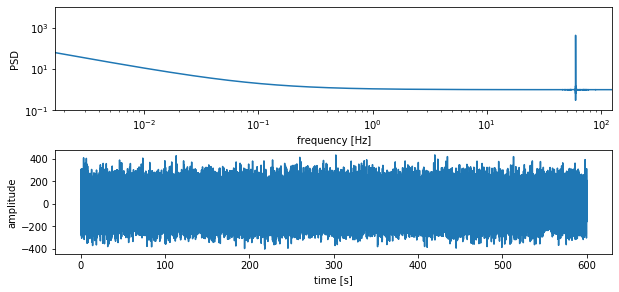

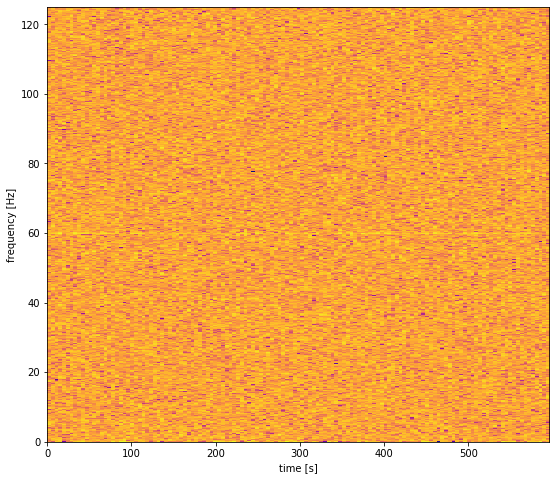

In [212]:
# Trzeci sygnał
s=2

freqCut[s] = 125 # Hz (częstotliwość odcięcia)
noiseFloor = 1 
pinkNoiseAmp = 0.1

cut = int(freqCut[s] * freqScale)
spec[s] = np.zeros(freqNum)
spec[s] = np.array(spec[s]) # spec = spectrum, deklaracja pustej tablicy N-elementowej

for i in range(1,cut+1,1):
    spec[s][i] = noiseFloor + pinkNoiseAmp / freq[i] # + np.random.normal(1, 0.1) #szum 1/f + szum biały

    
# zespolona amplituda szumu w domenie częstotliwości (z losowo nadanymi fazami) 
# freqSig zawiera pełną informację o sygnale
freqSig[s] = np.sqrt(spec[s])/2 + 0*1j # amplituda sygnału - pierwiastek z mocy (liczba zespolona)
for i in range(freqNum):
    freqSig[s][i] = freqSig[s][i] * np.exp(1j * 2*np.pi * np.random.uniform(0,1)) # nadaję losową fazę amplitudzie 


# można próbować dodać funkcję zespoloną w funkcji częstotliwości, która odpowiada jakiemuś sygnałowi czasowemu

    

# odwrotna FFT - przejście do domeny czasu

timeSig[s] = (freqNum-1)*np.fft.irfft(freqSig[s]).real


# można też dodać przebieg czasowy

sigWidth = 600 # szerokość funkcji (jednostka: s)
sigAmp = 100 # kwadrat amplitudy funkcji
position = 300 * sampleRate # pozycja środka dodawanego sygnału
frequency = 60 # Hz

x = np.linspace(0, sigWidth, sigWidth*sampleRate) # oś czasu
sig = sqrt(sigAmp) * np.sin(frequency * x * 2*np.pi) 
for i in range(int(position - x.size/2), int(position + x.size/2),1):
    if i <= timeNum and i >= 0:
        timeSig[s][i] = timeSig[s][i] + sig[i - int((position - x.size/2))]


# powrót do domeny częstotliwości        

freqSig[s] = np.fft.rfft(timeSig[s])/(freqNum-1)
spec[s] = np.power(2*abs(freqSig[s]),2)
    
    
# wykres

#PSD
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(freq[1:cut], spec[s][1:cut])
ax1.set(yscale = 'log', xscale = 'log', ylim = (0.1,10000), xlim = (1/freqScale, freqCut[s]),
        xlabel = "frequency [Hz]", ylabel = "PSD")

# przebieg czasowy
ax2.plot(timeLine, timeSig[s])
ax2.set(xlabel = "time [s]", ylabel = "amplitude")

# spektrogram
fig2, (ax3) = plt.subplots(1,1)
plt.sca(ax3)
ax3.set(xlabel = "time [s]", ylabel = "frequency [Hz]", ylim = (0,freqCut[s]), yscale = 'linear')
Pxx, freqs, bins, im = my_specgram(timeSig[s], NFFT=int(5 * sampleRate), 
                                       Fs=sampleRate, noverlap=int(sampleRate/2), 
                                       cmap = 'plasma',
                                       minfreq = 0, maxfreq = freqCut[s])

# ustawienia wykresu
fig.tight_layout(pad = 0.5) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(4)
fig.set_figwidth(9)
fig2.set_figheight(8)
fig2.set_figwidth(9)
plt.show()

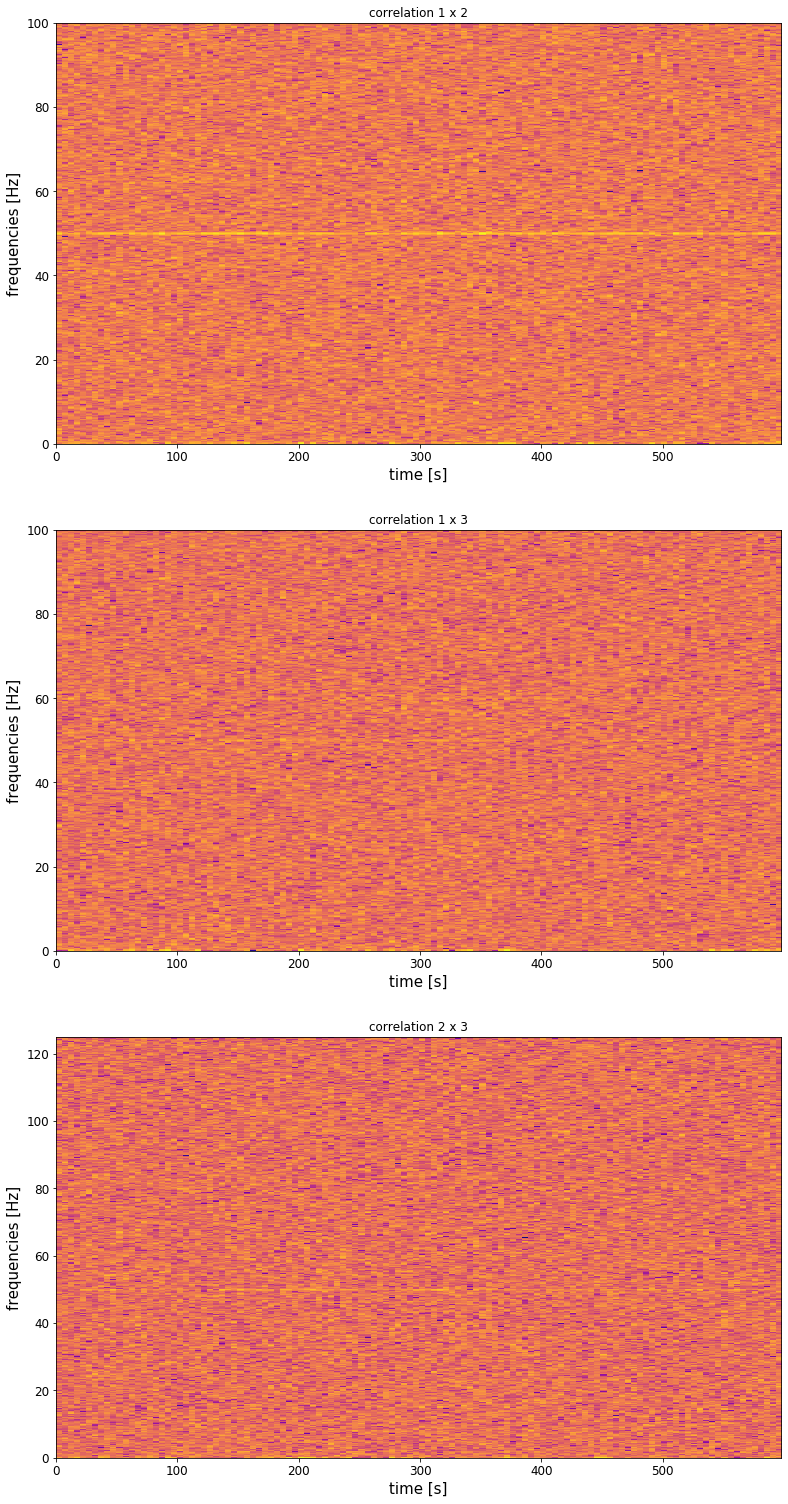

In [220]:
# Macierz korelacji (funkcje korelacji par sygnałów) - korelacje fragmentów sygnałów o zadanych długościach

timeInter = 5 # s - interwał czasowy
over = 5 # s - zachodzenie na siebie segmentów, na razie wersja uproszczona bez zachodzenia
inter = timeInter * sampleRate 
interFreq = int(inter/2)+1 # liczba punktów na wykresie w domenie częstotliwości
num = int(timeRange/timeInter) # liczba "kafli" (interwałów czasowych)

freqSigInterMatrix = np.zeros((3,3,num, interFreq), dtype=complex)
specInterMatrix = np.zeros((3,3,num, interFreq))
timeSigInterMatrix = np.zeros((3,3,num, inter))
timeSigCorr = np.zeros((3,3, num*inter))

fourier = np.zeros((3,int(interFreq)), dtype=complex)
PSD = np.zeros((3,interFreq))

for k in range(0,num,1):
    for i in range(0,3,1):
        fourier[i] = np.fft.rfft(timeSig[i][k*inter:(k+1)*inter]) / (freqNum-1) 
        PSD[i] = np.power(abs(2*fourier[i]),2)
    for i in range(0,3,1):
        for j in range(0,3,1):
            specInterMatrix[i][j][k] = PSD[i] * PSD[j]
            freqSigInterMatrix[i][j][k] = fourier[i] * fourier[j]
            timeSigInterMatrix[i][j][k] = (freqNum-1) * np.fft.irfft(freqSigInterMatrix[i][j][k]).real

for n in range(0,3,1):
    for m in range(0,3,1):
        for i in range(0,num,1):
            for j in range(0, inter,1):
                timeSigCorr[n][m][i*inter + j] = timeSigInterMatrix[n][m][i][j]
            


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

n,m = 0,1
plt.sca(ax1) # set current axis as ax1
Pxx1, freqs1, bins1, im1 = my_specgram(timeSigCorr[n][m], NFFT=int(timeInter * sampleRate),
                                   Fs=sampleRate, noverlap=0, cmap = 'plasma',
                                   minfreq = 0, maxfreq = min(freqCut[n],freqCut[m]))
ax1.set(title = "correlation 1 x 2")
ax1.set_ylabel("frequencies [Hz]", fontsize = 15)
ax1.set_xlabel( "time [s]", fontsize=15)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

n,m = 0,2
plt.sca(ax2)
Pxx2, freqs2, bins2, im2 = my_specgram(timeSigCorr[n][m], NFFT=int(timeInter * sampleRate),
                                   Fs=sampleRate, noverlap=0, cmap = 'plasma',
                                   minfreq = 0, maxfreq = min(freqCut[n],freqCut[m]))
ax2.set_title("correlation 1 x 3")
ax2.set_ylabel("frequencies [Hz]", fontsize = 15)
ax2.set_xlabel( "time [s]", fontsize=15)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

n,m = 1,2
plt.sca(ax3)
Pxx3, freqs3, bins3, im3 = my_specgram(timeSigCorr[n][m], NFFT=int(timeInter * sampleRate),
                                   Fs=sampleRate, noverlap=0, cmap = 'plasma',
                                   minfreq = 0, maxfreq = min(freqCut[n],freqCut[m]))
ax3.set_title( "correlation 2 x 3")
ax3.set_ylabel("frequencies [Hz]", fontsize = 15)
ax3.set_xlabel( "time [s]", fontsize=15)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)

# ustawienia wykresu
fig.tight_layout(pad = -5) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(18)
fig.set_figwidth(9)
plt.show()

In [7]:
# Próba wykreślenia spektrogramu innym sposobem 

"""
dataTime = np.zeros(interFreq * num)
dataVal = np.zeros(num*interFreq)

for i in range(0,num,1):
    for j in range(0, interFreq,1):
        dataTime[i*interFreq + j] = timeInter/2 + i*timeInter
        dataVal[i*interFreq + j] = specInterMatrix[1][1][i][j]
        
dataFreq = np.zeros(interFreq * num)
temp = np.linspace(0,freqRange,interFreq)

for i in range(0,num,1):
    for j in range(0,interFreq,1):
        dataFreq[i*interFreq + j] = temp[j]
        
data = {"time": dataTime, "freq": dataFreq, "val": dataVal }
import pandas as pd
df = pd.DataFrame(data)
df = df.pivot(index = "freq", columns = "time", values = "val")
sns.heatmap(df)
"""

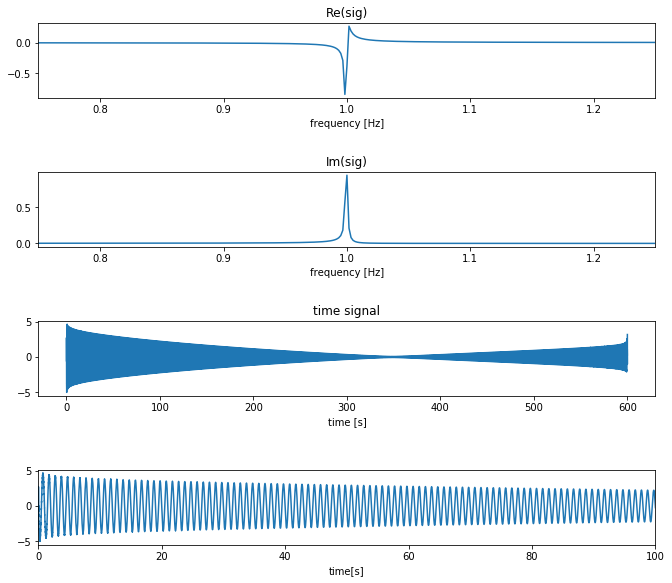

In [51]:
# Przykłady sygnałów bez szumu

# sig1 = zespolona amplituda piku, który w spektrum przyjmuje kształt lorentzianu
# faza amplitudy to arctan((x-xo)/\gamma)

freqSig1 = np.zeros(freqNum, dtype = complex)

lorWidth = 150 # szerokość funkcji (jednostka: Hz)
lorAmp = 100 # amplituda funkcji
#UWAGA! Przy zmianie \gamma może okazać się konieczna zmiana skali osi częstotliwości na wykresach
gamma = 0.0001 # parametr funkcji 
position = 1 * freqScale # pozycja środka dodawanego sygnału

x = np.linspace(0, lorWidth, lorWidth*sampleRate) # oś częstotliwości

lor = np.sqrt( lorAmp / (1 + np.power((x-lorWidth/2)/gamma,2)) ) + 0*1.j
# nadanie fazy:
lor = lor * np.exp( 1j * 2*np.pi * np.arctan(gamma/(x-lorWidth/2) % 2*np.pi))

for i in range(int(position - x.size/2), int(position + x.size/2),1):
    freqSig1[i] = lor[i - int((position - x.size/2))]
    
# generacja przebiegu czasowego
timeSig1 = (freqNum-1)*np.fft.irfft(freqSig1).real
    
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
ax1.plot(freq, freqSig1.real)
ax1.set(xlim = (position/freqScale - 0.25, position/freqScale + 0.25), title = "Re(sig)", xlabel = "frequency [Hz]")
ax2.plot(freq, freqSig1.imag)
ax2.set(xlim = (position/freqScale - 0.25, position/freqScale + 0.25), title = "Im(sig)", xlabel = "frequency [Hz]")
ax3.plot(timeLine, timeSig1)
ax3.set(title = "time signal", xlabel = "time [s]")
ax4.plot(timeLine, timeSig1)
ax4.set(xlim = (0,100), xlabel = "time[s]")

fig1.tight_layout(pad = -1) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig1.set_figheight(8)
fig1.set_figwidth(9)

plt.show()

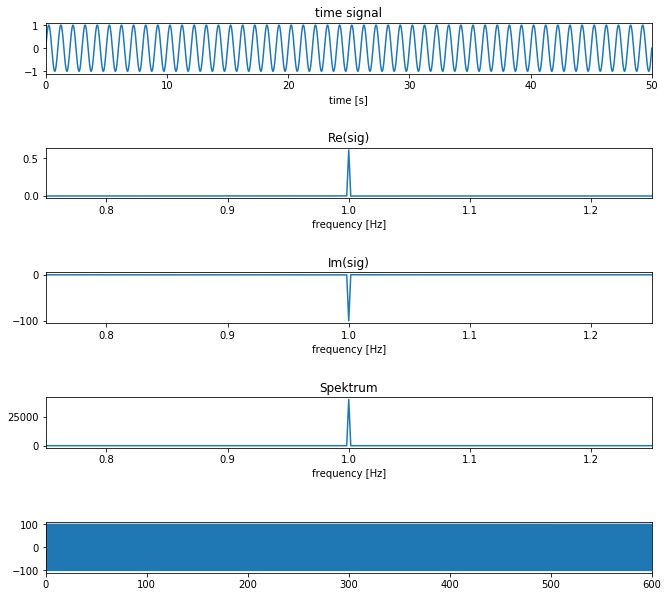

99.99999999869276

In [143]:
# odwrotnie: zaczynamy od sygnału sinusoidalnego i przechodzimy do domeny częstotliwości
pos = 1
timeSig2 = np.sin( pos * timeLine * 2*np.pi)
#for i in range(0,250 * sampleRate, 1):
 #   timeSig2[i] = 0;
 #   timeSig2[350*sampleRate+i] = 0;


freqSig2 = 100*np.fft.rfft(timeSig2)/(freqNum-1)

reverseTimeSig2 = (freqNum-1) * np.fft.irfft(freqSig2)

spec2 = np.power(2*abs(freqSig2),2)

fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)
ax1.plot(timeLine, timeSig2)
ax1.set(xlim = (0,50), title = "time signal", xlabel = "time [s]")
ax2.plot(freq, freqSig2.real)
ax2.set(xlim = (pos - 0.25, pos + 0.25), title = "Re(sig)", xlabel = "frequency [Hz]")
ax3.plot(freq, freqSig2.imag)
ax3.set(xlim = (pos - 0.25, pos + 0.25), title = "Im(sig)", xlabel = "frequency [Hz]")
ax4.plot(freq, spec2)
ax4.set(xlim = (pos - 0.25, pos + 0.25), title = "Spektrum", xlabel = "frequency [Hz]")
ax5.plot(timeLine, reverseTimeSig2)
ax5.set(xlim = (0,600))


fig2.tight_layout(pad = -1) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig2.set_figheight(8)
fig2.set_figwidth(9)

plt.show()
reverseTimeSig2[int(sampleRate/4)]